# pix2pix for predicting deforestation

pix2pix is a conditional GAN with a U-Net as the generator and a PatchGAN as the discriminator.

Adapted from [this notebook under the Apache license](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb).

In [1]:
import tensorflow as tf

import numpy as np

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [3]:
!ls drive/MyDrive/hacktech2021

2020  imgs  test


In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [18]:
def load(image_file, train=True):
    direc = './drive/MyDrive/hacktech2021/imgs/'
    if not train:
        direc = './drive/MyDrive/hacktech2021/test/'
    s = tf.strings.split(image_file, '/')[-1]
    t = tf.strings.split(s, '-')
    
    scene = int(t[-2].numpy())
    year = int(t[-1].numpy()[:-4])
    real_path = str(scene) + '-' + str(year + 1) + '.jpg'
    # Skip images before 2009
    if year < 2009:
      return None, None

    # Final image
    if year == 2019:
        real_path = './drive/MyDrive/hacktech2021/2020/' + real_path
    elif not train:
        real_path = './drive/MyDrive/hacktech2021/test/' + real_path
    else:
        real_path = './drive/MyDrive/hacktech2021/imgs/' + real_path
    
    input_image = tf.io.read_file(image_file)
    input_image = tf.image.decode_jpeg(input_image)
    
    real_image = tf.io.read_file(real_path)
    real_image = tf.image.decode_jpeg(real_image)[:, :, :3]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

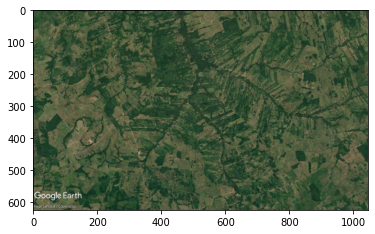

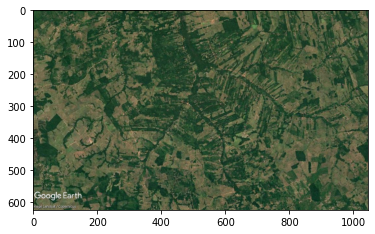

In [ ]:
inp, re = load('6-2019.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [6]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [8]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [9]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

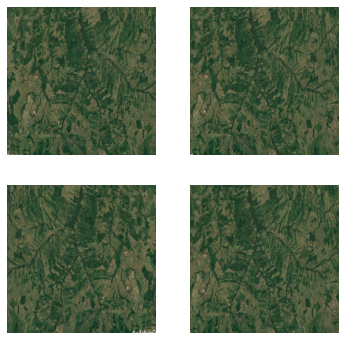

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [13]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  if input_image is None:
    return None, None
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [14]:
def load_image_test(image_file):
  input_image, real_image = load(image_file, train=False)
  if input_image is None:
    return None, None
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [19]:
train_dataset = tf.data.Dataset.list_files('./drive/MyDrive/hacktech2021/imgs/' + '*.jpg')
x_train = []
y_train = []
for t in train_dataset:
    x, y = load_image_train(t)
    if x is None:
      continue
    x_train.append(x)
    y_train.append(y)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [20]:
test_dataset = tf.data.Dataset.list_files('./drive/MyDrive/hacktech2021/test/' + '*.jpg')
x_test = []
y_test = []
for t in test_dataset:
    x, y = load_image_test(t)
    if x is None:
      continue
    x_test.append(x)
    y_test.append(y)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

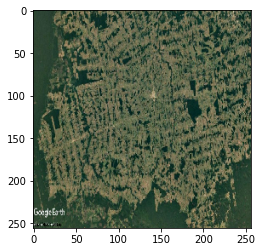

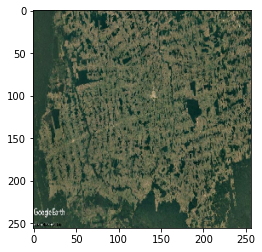

In [21]:
# Check dataset
for x, y in test_dataset.take(1):
  plt.figure()
  plt.imshow(x[0] * 0.5 + 0.5)
  plt.figure()
  plt.imshow(y[0] * 0.5 + 0.5)
  break

In [22]:
OUTPUT_CHANNELS = 3

In [23]:
# Convolutional layer followed by batch normalization and leaky ReLU
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

In [24]:
# Transposed convolutional layer followed by dropout and ReLU
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

In [25]:
# U-Net
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
    downsample(128, 4),  # (bs, 64, 64, 128)
    downsample(256, 4),  # (bs, 32, 32, 256)
    downsample(512, 4),  # (bs, 16, 16, 512)
    downsample(512, 4),  # (bs, 8, 8, 512)
    downsample(512, 4),  # (bs, 4, 4, 512)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512, 4),  # (bs, 16, 16, 1024)
    upsample(256, 4),  # (bs, 32, 32, 512)
    upsample(128, 4),  # (bs, 64, 64, 256)
    upsample(64, 4),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [26]:
generator = Generator()

In [ ]:
x, y = resize(inp, re, 286, 286)
x, y = random_crop(inp, re)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


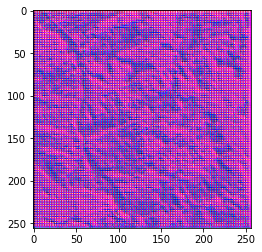

In [ ]:
gen_output = generator(x[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [27]:
LAMBDA = 100

In [28]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
# Compute generator loss with discriminator output
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [30]:
# PatchGAN
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [31]:
discriminator = Discriminator()

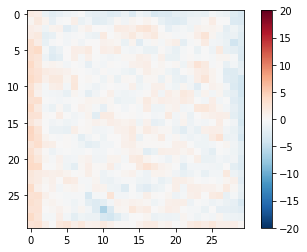

In [ ]:
disc_out = discriminator([x[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [32]:
# Compute discriminator loss with real/fake samples
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

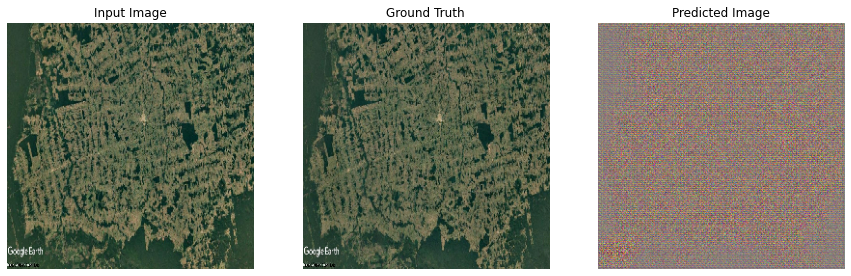

In [36]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [37]:
EPOCHS = 150

In [38]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [39]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [40]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

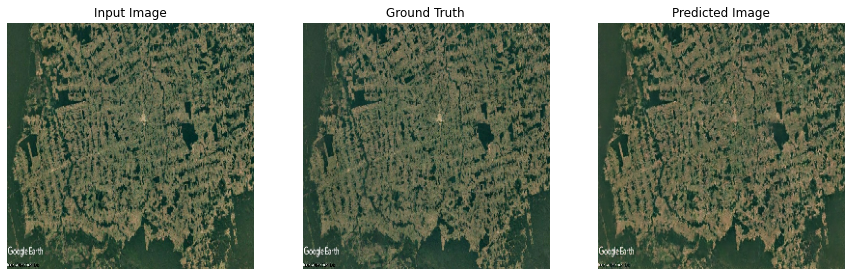

Epoch:  149
.....................................................................
Time taken for epoch 150 is 15.531129360198975 sec



In [41]:
fit(train_dataset, EPOCHS, test_dataset)

In [42]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

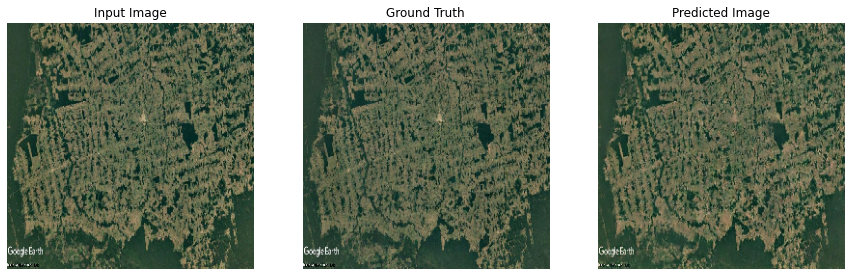

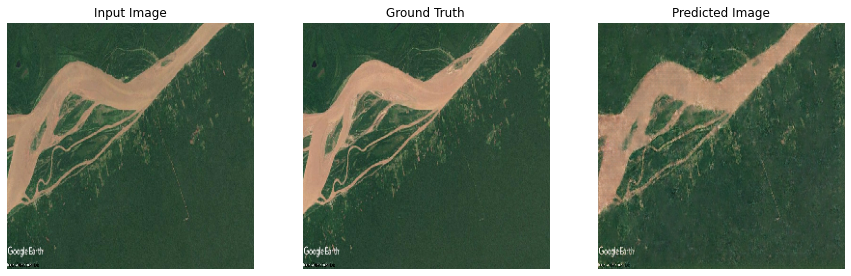

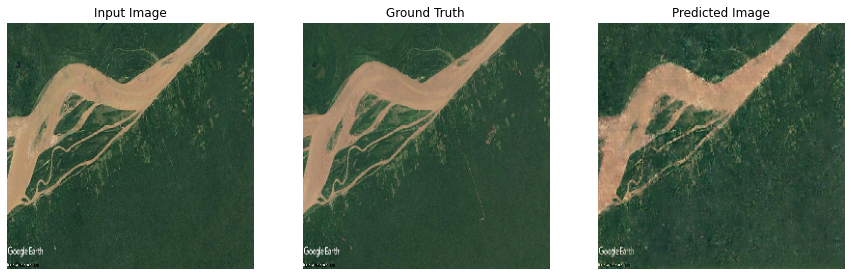

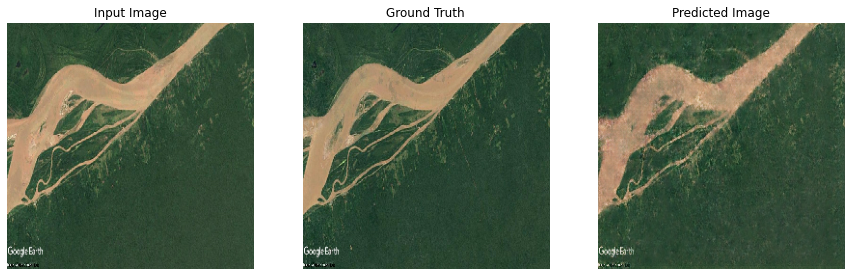

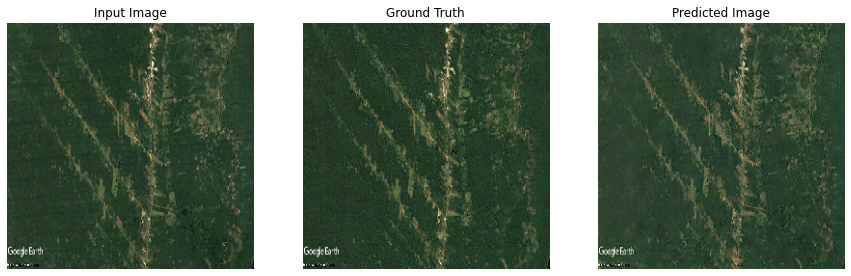

In [43]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [60]:
x, y = load('./drive/MyDrive/hacktech2021/test/30-2019.jpg', train=False)
x.shape

TensorShape([624, 1046, 3])

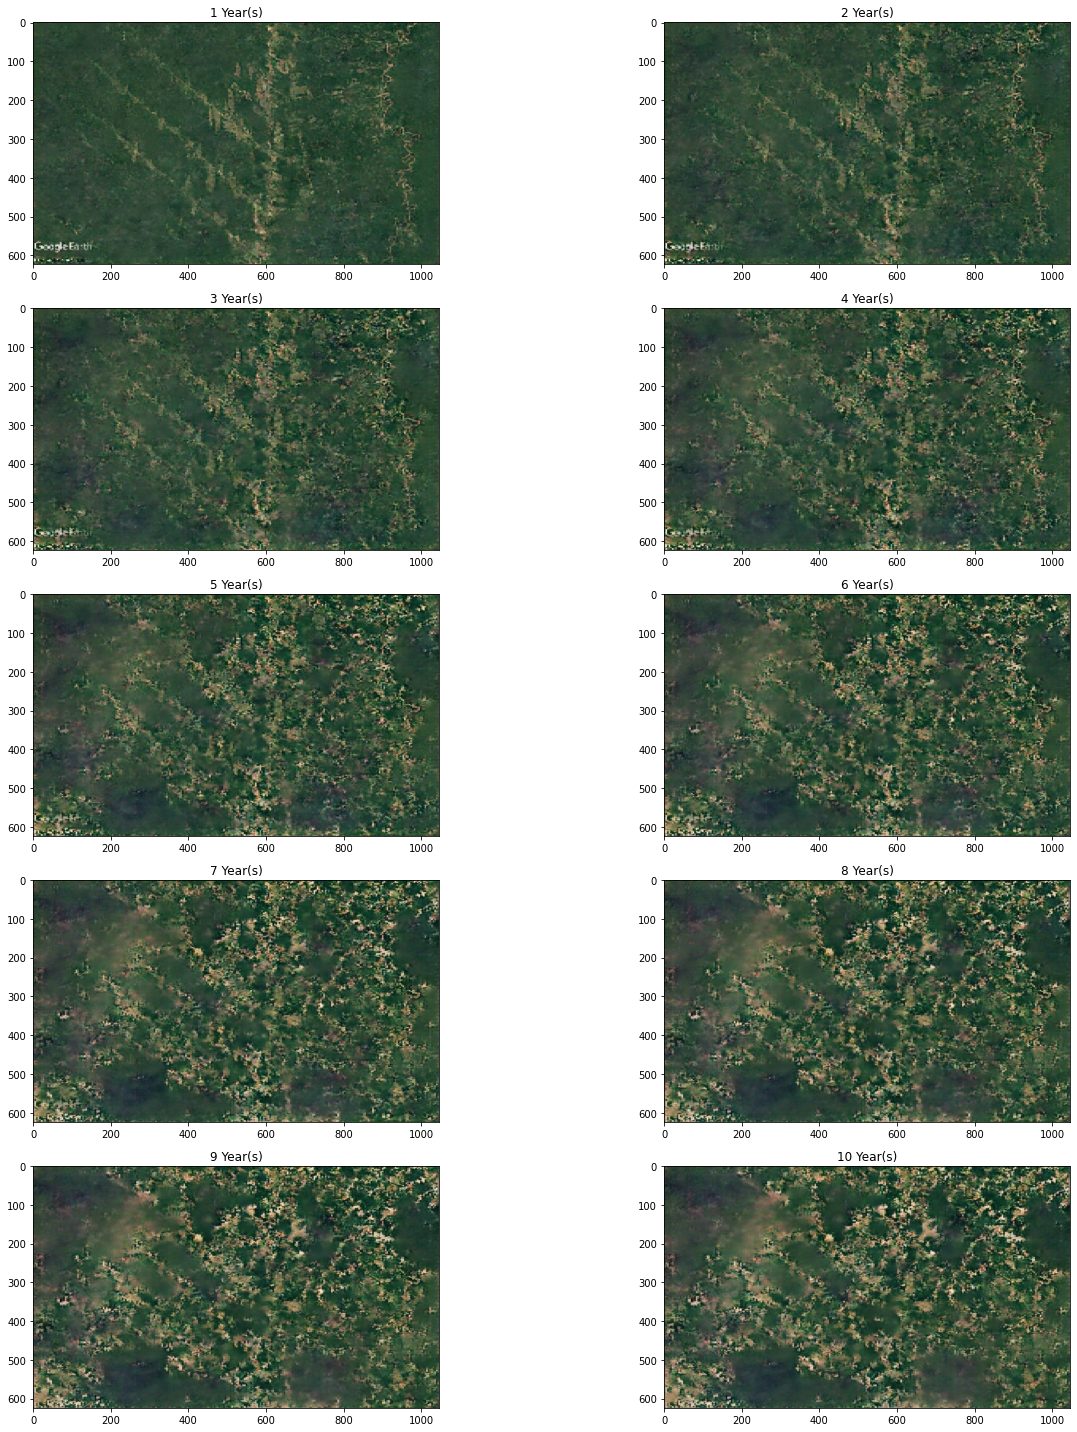

In [61]:
# Test prediction with above image 
# Seems to be okay until after 5 years
x, y = resize(x, y, 256, 256)
x, _ = normalize(x, y)
x = np.expand_dims(x, axis=0)
plt.figure(figsize=(20, 20))
for i in range(10):
    x = generator(x, training=True)
    plt.subplot(5, 2, i + 1)
    img, _ = resize(x[0] * 0.5 + 0.5, x[0] * 0.5 + 0.5, 624, 1046)
    img = img.numpy() 
    plt.imshow(img)
    plt.title(f'{i+1} Year(s)')
plt.tight_layout()
plt.savefig('pred30.jpg')